In [ ]:
!pip3 install pyro-ppl

In [ ]:
##RCS DATA##

In [2]:
from preproc import preprocess_rsc15
dat, ind2val = preprocess_rsc15(limit_train = 10000, limit_test = 1000)


# Transform into sequence interaction object
from spotlight.interactions import Interactions, SequenceInteractions
dat_seq = {}
for name, df in dat.items():
    dat_seq[name] = Interactions(user_ids=df.SessionId_idx.values,
                item_ids=df.ItemId_idx.values,
                timestamps=df.Time.values).to_sequence()

ModuleNotFoundError: No module named 'ludewig'

In [1]:
## GENERATED DATA ##

from spotlight.datasets.synthetic import generate_sequential
from spotlight.cross_validation import user_based_train_test_split

dataset = generate_sequential(num_users=100,
                              num_items=1000,
                              num_interactions=10000,
                              concentration_parameter=0.0001,
                              order=3)

dat_seq = {key: dat.to_sequence() for key, dat in zip(["train","test"], user_based_train_test_split(dataset))}

In [2]:
import pyro.distributions as dist
from pyro import plate
from pyro.distributions import Categorical
import pyro
import torch.nn as nn
import torch
import torch.distributions.constraints as constraints
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from spotlight.evaluation import sequence_mrr_score
import matplotlib.pyplot as plt

In [3]:
class LSTMVI(nn.Module):
    def __init__(self, num_items, emb_dim, use_cuda = True):
        super(LSTMVI, self).__init__()
        self.num_items = num_items
        self.emb_dim = emb_dim
        
        #self.V = pyro.param("item_mat", torch.rand(num_items, emb_dim)-0.5)
        
        
        ### LSTM
        self.lstm = nn.LSTM(batch_first=True,
                                input_size=self.emb_dim,
                                hidden_size=self.emb_dim)
        
        # Need to permute before and after LSTM because LSTM's batch_first is not supported...
        self.permute_for_lstm = lambda x: x.permute(1,0,2)
        self.permute_back_lstm = lambda x: x.permute(1,0,2)
        
        ### CUDA
        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        

    
    def model(self, x):
        seq = torch.tensor(x.sequences).long()
        pyro.module("lstm", self.lstm)
        mu0 = torch.zeros(self.emb_dim)#.cuda()
        var0 = torch.diag(torch.ones(self.emb_dim))*0.01

        muV = pyro.sample("muV", dist.MultivariateNormal(loc = mu0, covariance_matrix= var0))
        varU = varV = var0

        with plate("item_loop", self.num_items):
            V = pyro.sample(f"V", dist.MultivariateNormal(muV, varV))#.cuda()

        with pyro.plate("data", len(seq), subsample_size=50) as ind:
            x_vecs = V[seq[ind,]]
            z, _ = self.lstm(x_vecs)
            lprob = z.matmul(V.t())
            
            data = pyro.sample("obs_x", 
                               dist.Categorical(logits=lprob).to_event(2), 
                               obs = seq[ind,])

    def guide(self, x):
        
        # GLOBAL V:
        muV_mean = pyro.param("muV_mean", torch.rand(self.emb_dim))
        muV_std = pyro.param("muV_std", torch.rand(self.emb_dim), constraint = constraints.positive)
        muV_covar = torch.diag(muV_std)
        pyro.sample("muV", dist.MultivariateNormal(muV_mean, muV_covar))
        
        ## INDIVIDUAL V's
        varV = pyro.param("varV", torch.ones(self.emb_dim), constraint = constraints.positive)
        item_var = pyro.param("item_var_factor", torch.rand(self.num_items)+0.5, 
                              constraint = constraints.positive) #.to(device)
        covarV = torch.diag(varV)*item_var.view(-1,1,1)
        V = pyro.param("Vpar", torch.rand(self.num_items, self.emb_dim))

        ## item latent vectors
        with plate("item_loop", self.num_items) as i:
            V = pyro.sample(f"V", dist.MultivariateNormal(V[i,], covarV[i,])) #.to(device)
        

In [4]:
def compute_hitrate(dat, k = 20, tau = 6):
    seq = torch.tensor(dat.sequences).long()
    feature_seq = seq[:,:tau]
    test_seq = seq[:,tau:]

    V = pyro.param("Vpar")

    x_vecs = V[feature_seq]
    z, _ = svi_mf.lstm(x_vecs)
    lprob = z.matmul(V.t())
    topK = lprob.argsort(dim=2, descending=True)[:,-1,:k]

    hitrate = torch.tensor(0.0)
    failrate = torch.tensor(0.0)
    for i in range(len(seq)):
        hitmatrix = topK[i].unsqueeze(1) == test_seq[i].unsqueeze(0)
        hitrate += hitmatrix.sum()
        failrate += (hitmatrix == 0).sum()
        
    return (hitrate/failrate).item()

In [5]:
print("Initializing model")
pyro.clear_param_store()
seq = dat_seq['train'].sequences
x = torch.from_numpy(seq[:500,6:]).long()#.cuda()

svi_mf = LSTMVI(1000, emb_dim = 4, use_cuda = False)

Initializing model


step: 0 	 loss: 2825476 	 hitrate_tr: 0.0014 	 hitrate_test: 0.0008


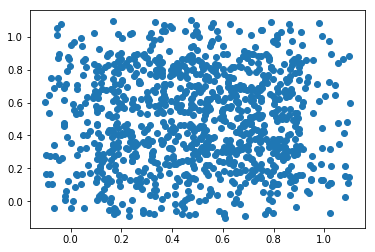

step: 50 	 loss: 2097205 	 hitrate_tr: 0.0062 	 hitrate_test: 0.0038
step: 100 	 loss: 1868518 	 hitrate_tr: 0.0063 	 hitrate_test: 0.0054
step: 150 	 loss: 1969126 	 hitrate_tr: 0.0079 	 hitrate_test: 0.0052
step: 200 	 loss: 2001686 	 hitrate_tr: 0.0070 	 hitrate_test: 0.0052


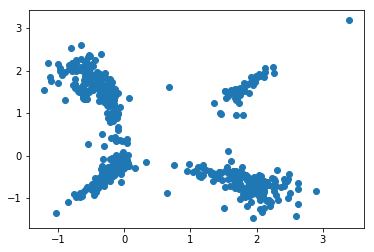

step: 250 	 loss: 1954822 	 hitrate_tr: 0.0073 	 hitrate_test: 0.0055
step: 300 	 loss: 1944858 	 hitrate_tr: 0.0066 	 hitrate_test: 0.0048
step: 350 	 loss: 1975202 	 hitrate_tr: 0.0071 	 hitrate_test: 0.0050
step: 400 	 loss: 1935483 	 hitrate_tr: 0.0077 	 hitrate_test: 0.0044


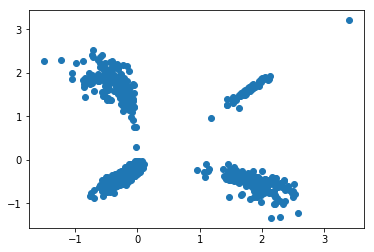

step: 450 	 loss: 1951379 	 hitrate_tr: 0.0069 	 hitrate_test: 0.0053
step: 500 	 loss: 1936997 	 hitrate_tr: 0.0060 	 hitrate_test: 0.0040
step: 550 	 loss: 1962542 	 hitrate_tr: 0.0069 	 hitrate_test: 0.0047
step: 600 	 loss: 1859576 	 hitrate_tr: 0.0077 	 hitrate_test: 0.0052


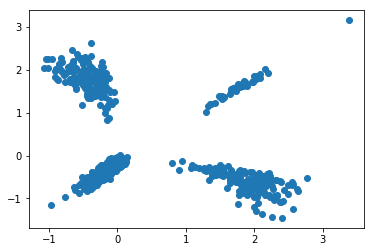

step: 650 	 loss: 2031084 	 hitrate_tr: 0.0064 	 hitrate_test: 0.0049
step: 700 	 loss: 2032283 	 hitrate_tr: 0.0069 	 hitrate_test: 0.0044
step: 750 	 loss: 1898746 	 hitrate_tr: 0.0072 	 hitrate_test: 0.0051
step: 800 	 loss: 1950159 	 hitrate_tr: 0.0072 	 hitrate_test: 0.0050


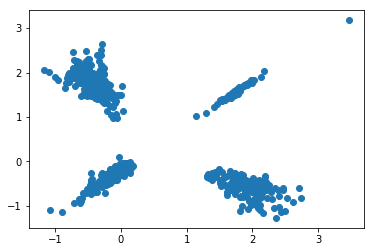

step: 850 	 loss: 2034118 	 hitrate_tr: 0.0072 	 hitrate_test: 0.0050
step: 900 	 loss: 1949024 	 hitrate_tr: 0.0071 	 hitrate_test: 0.0049
step: 950 	 loss: 2009142 	 hitrate_tr: 0.0077 	 hitrate_test: 0.0049
CPU times: user 1min 49s, sys: 5.94 s, total: 1min 55s
Wall time: 1min 55s


In [6]:
%%time
n_steps = 1000
pyro.clear_param_store()

# set up the optimizer
adam_params = {"lr": 0.1}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(svi_mf.model, svi_mf.guide, optimizer, loss=Trace_ELBO())

imgs = []
# do gradient steps
for step in range(n_steps):
    loss = svi.step(dat_seq['train'])

    if step%50== 0:
        # RMSE
        hitrate_train = compute_hitrate(dat_seq['train'], k = 10)
        hitrate_test = compute_hitrate(dat_seq['test'], k = 10)

        print(f"step: {step} \t loss: {loss:.0f} \t hitrate_tr: {hitrate_train:.4f} \t hitrate_test: {hitrate_test:.4f}") # \t test-rmse: {rmse_test:.2f}
    if step%200==0:    
        V = pyro.param("Vpar").detach().numpy()
        img = plt.plot(V[:,0], V[:,1], "o", animated=True)
        imgs.append(img[0])
        plt.show()
        